## Histogram of Gradients (HOG)

The aim of this notebook is to obtain merely HOG images out of the original images. The HOG images are being used as the 4th channel, next to the 3 channels RGB.

### Importing

In [1]:
# Import required packages 
import tensorflow as tf
import image_modeling   # import image_modeling.py file
import tensorflow_hub as hub
import datetime
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import data, exposure
import cv2 as cv2

# Load the TensorBoard notebook extension
%load_ext tensorboard

/Users/lee/neuefische/Capstone_Project_Turtle_Recall/.venv/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [ ]:
#!python -m pip install -U scikit-image
#!pip install opencv-python

In [2]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [2]:
# Import variables from image_modelling.py file
HEIGHT = image_modeling.HEIGHT
WIDTH = image_modeling.WIDTH
NCLASSES = image_modeling.NCLASSES
CLASS_NAMES = image_modeling.CLASS_NAMES
BATCH_SIZE = image_modeling.BATCH_SIZE
TRAINING_SIZE = image_modeling.TRAINING_SIZE
TRAINING_STEPS = (TRAINING_SIZE // BATCH_SIZE)

train_data = image_modeling.train_data
lines = image_modeling.lines
image_dir = image_modeling.image_dir
length_data = image_modeling.length_data

### Rescaling

To create HOG images out of the original images, they have to be preprocessed: rescaled, but not augmentated, hence augment = False. Here, train_datagen and test_datagen are identical, just the information of rescaling, the images itself are not involved yet.

In [4]:
train_datagen, test_datagen = image_modeling.preprocess(augment=False)

### From dataframe to arrays: train validation split and batches

The function use_image_generator is also used in the notebook "Create Pipeline" and copied into image_modeling.py. Now the data were split into a test and validation dataset. However, much has to be changed here, that's why use_image_generator is defined newly with updated changes: class_mode = None, because the label data are cumbersome, therefore also shuffle = False.

In [134]:
def use_image_generator(train_datagen, test_datagen): 
        train_generator = train_datagen.flow_from_dataframe(dataframe =train_data[0:lines], 
                directory   = image_dir,
                x_col       = "image_id" ,
                target_size = (HEIGHT, WIDTH),
                batch_size  = BATCH_SIZE,
                classes     = CLASS_NAMES,
                class_mode  = None,
                #color_mode  = 'grayscale',                                            
                shuffle     = False)
        
        validation_generator = test_datagen.flow_from_dataframe(dataframe = train_data[lines:], 
                directory    = image_dir,
                x_col        = "image_id",
                target_size  = (HEIGHT, WIDTH),
                batch_size   = BATCH_SIZE,
                classes      = CLASS_NAMES,
                class_mode   = None,
                #color_mode  = 'grayscale',                                                
                shuffle      = False)
        
        return train_generator, validation_generator

Now the images were loaded from the dataframe using the use_image_generator function above. They are loaded into batches with the size BATCH_SIZE. The batching process is unnecessary but uncommenting "batch_size" didn't help to avoid batching.

In [7]:
train_generator, validation_generator = use_image_generator(train_datagen, test_datagen)

Found 1502 validated image filenames.
Found 643 validated image filenames.


/Users/lee/neuefische/Capstone_Project_Turtle_Recall/.venv/lib/python3.9/site-packages/keras_preprocessing/image/dataframe_iterator.py:219: UserWarning: `classes` will be ignored given the class_mode="None"
  warnings.warn('`classes` will be ignored given the class_mode="{}"'


### Get the labels

In [14]:
train_labels_list = list(train_data.iloc[0:lines]["turtle_id"])
validation_labels_list = list(train_data.iloc[lines:]["turtle_id"])

### Create HOG images

The function get_hog takes the generators generated by the use_image_generator function as input. The outputs are all 1D HOG images and all 2D images, if visualize = True.

In [127]:
def get_hog(images_in_batches, visualize=True):    
    if visualize == True:
        hog_images = []
        bilder = []
        _ = 0
        for i in range(len(images_in_batches)):
            for j in range(BATCH_SIZE):
                fd, bild = hog(images_in_batches[i][j], orientations=9, pixels_per_cell=(16, 16),cells_per_block=(2, 2), channel_axis=-1, visualize=True)
                hog_images.append(fd)
                bilder.append(bild)
                _ += 1
                if _ >= images_in_batches.samples:
                    break
        hog_images = np.array(hog_images)
        bilder = np.array(bilder)
        return hog_images, bilder

    else:
        hog_images = []
        _ = 0
        for i in range(len(images_in_batches)):
            for j in range(BATCH_SIZE):
                fd = hog(images_in_batches[i][j], orientations=9, pixels_per_cell=(16, 16),cells_per_block=(2, 2), channel_axis=-1)
                hog_images.append(fd)
                _ += 1
                if _ >= images_in_batches.samples:
                    break
        hog_images = np.array(hog_images)            
        return hog_images

As a next step, the get_hoc function can be used. Attention, it takes long time to run through:

In [128]:
# 15 Minuten ACHTUNG
train_hog, train_hog_2d = get_hog(train_generator)
validation_hog, validation_hog_2d = get_hog(validation_generator)

### Add HOG images as a 4th channel

In [130]:
def add_fourth_channel(existing_images_in_batches,new_images_2d):    
    merged_all = []
    _ = 0
    for i in range(len(existing_images_in_batches)):
        for j in range(BATCH_SIZE):
            c1,c2,c3 = cv2.split(existing_images_in_batches[i][j])
            merged_image = cv2.merge((c1,c2,c3,new_images_2d[_]))
            merged_all.append(merged_image)
            _ += 1
            if _ >= existing_images_in_batches.samples:
                break        
    return np.array(merged_all)

In [137]:
alles = add_fourth_channel(train_generator,train_hog_2d)

KeyboardInterrupt: 

### Save files with pickle

In [ ]:
pickle_out_alles = open("alles.pickle","wb") #wb write binary
pickle.dump(alles,pickle_out_alles) #dump train to pickle_out
pickle_out_alles.close()

pickle_in_alles = open("alles.pickle","rb") #read binary
pickle_in_alles_load =  pickle.load(pickle_in_alles) #load pickle file

TypeError: Invalid shape () for image data

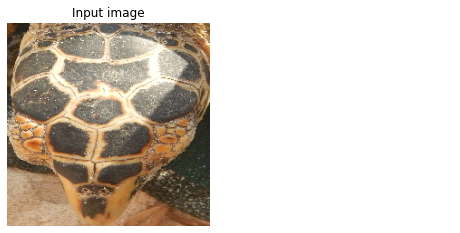

In [136]:
for i in range(10):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

    ax1.axis('off')
    ax1.imshow(train_generator[0][i], cmap=plt.cm.gray)
    ax1.set_title('Input image')

# Rescale histogram for better display
    hog_image_rescaled = exposure.rescale_intensity(train_hog[1][i], in_range=(0, 10))

    ax2.axis('off')
    ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
    ax2.set_title('Histogram of Oriented Gradients')
    plt.show()

In [ ]:
#split images into two
#img is our picture
#arr is the 4th channel
c1,c2 = cv2.split(img)
#then merge it into one again with another channel
merged = cv2.merge((c1,c2,arr))

In [57]:
c1,c2,c3 = cv2.split(train_generator[0][0])
merged_first = cv2.merge((c1,c2,c3,train_hog[1][0]))

In [81]:
train_generator[0][0].shape

(224, 224, 3)

In [67]:
merged_first[:,:,1].shape

(224, 224)

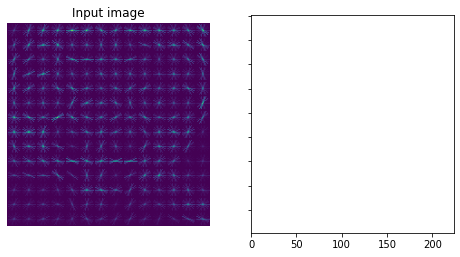

In [82]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

    ax1.axis('off')
    ax1.imshow(merged_first[:,:,3])
    ax1.set_title('Input image')

    plt.show()

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
model = LinearSVC()
model.fit(train_hog1, train_labels_list)
#%% Evaluate the classifier
print(" Evaluating classifier on test data ...")
predictions = model.predict(validation_hog1)
print(classification_report(validation_labels_list, predictions))